### Conditional Expectation method for missing values replacement
<span style="color:grey; font-size: 14px">
May 16, 2024 <br>
by Piotr Durawa 
</span>
<br/>
<br/>
Handling missing values is a common challenge in real-world datasets, where empty cells can disrupt analysis. These “missing values” need to be addressed before we can effectively use the data. To bridge these gaps, we often turn to strategies like using the mean or median of a feature, or simply removing the incomplete records. Using the mean or median is a straightforward solution, especially when features are uncorrelated. By calculating the global mean of a specific feature and filling in the missing values, we can quickly patch the dataset. However, this method might compromise the data integrity.

Let's delve into a practical example: obesity classification. Imagine our dataset includes height, weight, and an obesity label. Now, suppose some weight entries are missing. We want to retain these records, so we need to estimate the missing weights. If we choose to fill in these gaps with the average weight—say, 70 kg—we might end up with distorted data. Table [1](#tab1) illustrates this with three artificial records where the weight is replaced by the mean value of 70 kg. The obesity column shows the true labels, while the model prediction column displays the predictions from a well-trained model. 

<a id="tab1">Table 1.</a> Sample records with weight replaced by mean value.
| Weight [kg]|  Height [cm] |  Obesity  | Model prediction |
|---|---|---| --- |
| 70 | 140  | Normal weight  | Obese |
| 70 | 170  | Overweight | Normal weight |
| 70 | 210  | Normal weight | Underweight |


Observations:
- For the first person, the mean weight is too high, leading the model to classify them as "Obese".
- For the second person, the mean value is too low, causing the model to predict "Normal weight" despite the ground truth being "Overweight". The missing value should be higher.
- The third person is very tall with a "Normal weight" label. However, the mean value is too low, and the model predicts "Underweight".

Clearly, data integrity suffers when missing values are replaced with the mean.

An intuitive observation is that weight and height are correlated. Therefore, it might be possible to estimate an unknown weight based on the known height value. Additionally, considering the obesity label could further improve the accuracy of these estimates.


In this notebook, we will attempt to solve this problem using the conditional expectation method. By leveraging the relationship between height and weight, we aim to more accurately estimate the missing weight values and preserve the integrity of our dataset.  


### Dataset info
The notebook uses The Complete Pokemon Dataset. The analysis is based only on a specific subset of Pokemon features (weight and height).

[Dataset](#ref3): 
- Author: Rounak Banik
- Title: The Complete Pokemon Dataset
- Source: https://www.kaggle.com/datasets/rounakbanik/pokemon
- License: CC0: Public Domain

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import multivariate_normal

seed = 4321
np.random.seed(seed=seed)

## Load and prepare dataset

Data preparation consists of:
- selecting only specific features ['weight_kg', 'height_m']
- trimming dataset to smaller subset ['weight_kg' < 200 >, 'height_m' < 4]

In [14]:
df_original = pd.read_csv("data/pokemon.csv")
df_original = df_original[['weight_kg', 'height_m']]
df_original = df_original.loc[df_original['weight_kg'] < 200]
df_original = df_original.loc[df_original['height_m'] < 4]
df_original = df_original.reset_index(drop=True)

df_original

,weight_kg,height_m
0,6.9,0.7
1,13.0,1.0
2,100.0,2.0
3,8.5,0.6
4,19.0,1.1
...,...,...
714,55.5,1.2
715,25.0,1.8
716,100.0,3.8
717,0.1,0.3


## Plot data and calculate correlation

Scatter plot and correlation matrix shows us that height and weight features are correlated. Later, we will use this relationship to guess values that are missing. There are no missing values in the dataset yet, but we will inject them artificially in a moment.

Data scatter plot:


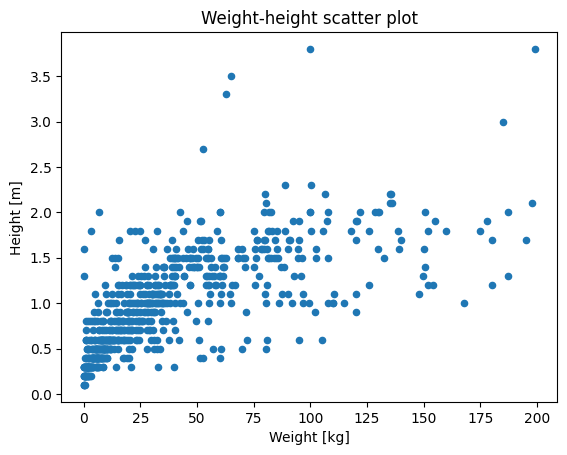

Features correlation


,weight_kg,height_m
weight_kg,1.000000,0.706155
height_m,0.706155,1.000000


In [15]:
print("Data scatter plot:")
df_original.plot.scatter(x='weight_kg', y='height_m')
plt.xlabel("Weight [kg]")
plt.ylabel("Height [m]")
plt.title("Weight-height scatter plot")
plt.show()
print("Features correlation")
df_original[['weight_kg', 'height_m']].corr()

## Missing values injection
To simulate dataset with missing values, weights of randomly choosen Pokemons will be replaces with NaN.

In [16]:
# replace 20% of weight values with NA
df_random_dict = {'mask': [np.random.uniform(0, 1) for i in range(len(df_original))]}
df_random = pd.DataFrame(df_random_dict)
df_mask = df_random < 0.2
df = df_original.copy()
df.loc[df_mask['mask'], 'weight_kg'] = float('nan')
df.to_json("assets/dataset.json", orient='records')
df

,weight_kg,height_m
0,NaN,0.7
1,13.0,1.0
2,100.0,2.0
3,8.5,0.6
4,NaN,1.1
...,...,...
714,55.5,1.2
715,25.0,1.8
716,100.0,3.8
717,0.1,0.3


## Replace missing values with mean

In the cell below missing weight values have been replaced with the mean weight. 

In [17]:
# calculate mean
weight_mean = df.loc[~df['weight_kg'].isna(), 'weight_kg'].mean()
print("Weight's mean:", weight_mean)
# replace NaNs with mean
df_mean_replacement = df.copy()
df_mean_replacement.loc[df_mean_replacement['weight_kg'].isna(), 'weight_kg'] = weight_mean

nan_pokemons_ind = df.loc[df['weight_kg'].isna()].index
print("Pokemons with missing weights:")
print(df.iloc[nan_pokemons_ind])
print("Result:")
print(df_mean_replacement.iloc[nan_pokemons_ind])
df_mean_replacement.to_json("assets/dataset_mean_replacement.json", orient='records')


Weight's mean: 38.249378330373005
Pokemons with missing weights:
     weight_kg  height_m
0          NaN       0.7
4          NaN       1.1
8          NaN       1.6
26         NaN       0.5
29         NaN       0.6
..         ...       ...
693        NaN       2.0
699        NaN       2.3
700        NaN       0.3
709        NaN       1.8
711        NaN       1.9

[156 rows x 2 columns]
Result:
     weight_kg  height_m
0    38.249378       0.7
4    38.249378       1.1
8    38.249378       1.6
26   38.249378       0.5
29   38.249378       0.6
..         ...       ...
693  38.249378       2.0
699  38.249378       2.3
700  38.249378       0.3
709  38.249378       1.8
711  38.249378       1.9

[156 rows x 2 columns]


## Mean value method - errors

The cell below calculates root mean square error and maximum absolute difference between original dataframe before injection of missing values and dataframe after missing values replacement.

In [18]:
## calculate errors
def rmse(df1, df2):
    diffs = df1 - df2
    squared_diffs = diffs**2
    mean_squared_diffs = squared_diffs.mean()
    rmse = np.sqrt(mean_squared_diffs)
    return rmse

def maximum_absolute_diff(df1, df2):
    diffs = df1 - df2
    absolute_diffs = np.abs(diffs)
    return np.max(absolute_diffs)

# calculate RMSE and maximum absolute difference
error_mean = rmse(df_original.loc[nan_pokemons_ind, 'weight_kg'], df_mean_replacement.loc[nan_pokemons_ind, 'weight_kg'])
print("\n")
print("Mean value method - RMSE: {:.2f}".format(error_mean))
max_absolute_diff = maximum_absolute_diff(df_original['weight_kg'], df_mean_replacement['weight_kg'])
print("Mean value method - Maximum absolute difference: {:.2f}".format(max_absolute_diff))



Mean value method - RMSE: 35.60
Mean value method - Maximum absolute difference: 148.75


## Mean value method conclusions

First, we calculated the mean value of weight and used it to replace each missing record. The mean weight is 38.25 kg. The table with the replaced records is shown below.

The errors for this method are as follows:

- Mean Value Method - RMSE: 35.60
- Mean Value Method - Maximum Absolute Difference: 148.75

These metrics will serve as a baseline to compare with the more sophisticated conditional expectation approach.

## Conditional expectation value method
Given the correlation between height and weight, we can use the known height to better estimate the missing weight values. This can be achieved using the conditional expectation method. But how do we calculate the conditional expectation of weight given the height?

Assume we have two random variables, $X$ (weight) and $Y$ (height), and the height value is already known $Y = y$. We can calculate the conditional probability as a weighted sum of $X$ values and their conditional probabilities $p(X | Y)$. Mathematically, this can be expressed as [[1]](#ref1), [[2]](#ref2):

$$
E[X|Y = y] = \sum_{x}p(x|y)\cdot x
$$

This equation tells us that the expected value of weight, given a specific height, is a sum of all possible weights weighted by their conditional probabilities given the height. This approach leverages the relationship between the variables to provide a more accurate estimation than simple mean replacement.

## Model probability distribution function

To model probability density function (PDF) for our dataset we will use Multivariate Gaussian Distribution. However, if your data does not follow common distributions you can use Kernel Density Estimation to model a PDF.

Mean: 
 [38.2493782  0.9769094]
Covariance matrix: 
 [[1.63448162e+03 1.57036866e+01]
 [1.57036866e+01 3.03807508e-01]]


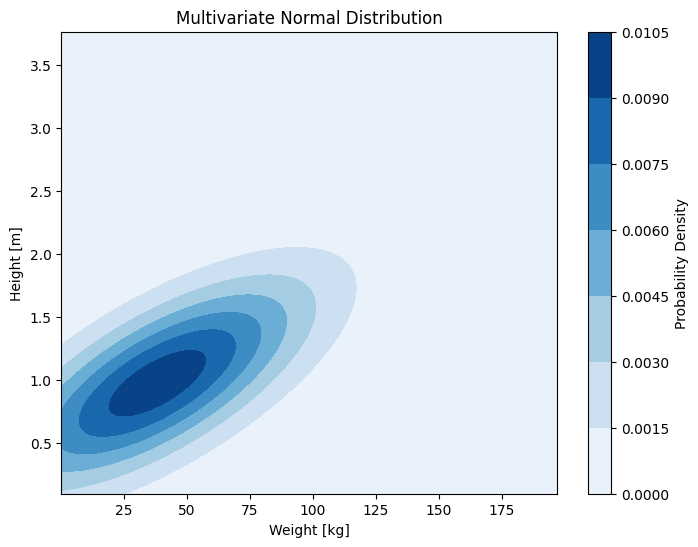

In [19]:
def calculate_mean_cov(df):
    # calculate mean and covariance
    mean = np.mean(np.array(df, dtype=np.float32), axis=0)
    cov_mat = np.cov(np.array(df, dtype=np.float32), rowvar=False)
    return mean, cov_mat

def model_pdf(df):
    df_copy = df.copy()
    df_no_nans = df_copy.loc[~df_copy.isna().any(axis=1)]
    mean, cov_mat = calculate_mean_cov(df_no_nans)
    multi_normal_dist = multivariate_normal(mean, cov_mat)
    return multi_normal_dist

def conditional_expectation(marginal, domain):
    expected_value = np.sum(domain * marginal) / np.sum(marginal)
    return expected_value

multi_normal_dist = model_pdf(df)
print("Mean: \n", multi_normal_dist.mean)
print("Covariance matrix: \n", multi_normal_dist.cov)

# visualize distribution
df_copy = df.copy()
df_no_nans = df_copy.loc[~df_copy.isna().any(axis=1)]
height_range = {"min": min(df_no_nans['height_m']),
                "max": max(df_no_nans['height_m'])}
weight_range = {"min": min(df_no_nans['weight_kg']),
                "max": max(df_no_nans['weight_kg'])}
num_samples = 100
intervals = {"height": (height_range['max'] - height_range['min']) / num_samples,
             "weight": (weight_range['max'] - weight_range['min']) / num_samples}
height_grid, weight_grid = np.mgrid[height_range["min"]:height_range["max"]:intervals["height"],
                                    weight_range["min"]:weight_range["max"]:intervals["weight"]]
pos = np.dstack((weight_grid, height_grid))

plt.figure(figsize=(8, 6))
plt.contourf(weight_grid, height_grid, multi_normal_dist.pdf(pos), cmap='Blues')
plt.colorbar(label='Probability Density')
plt.xlabel('Weight [kg]')
plt.ylabel('Height [m]')
plt.title('Multivariate Normal Distribution')
plt.show()

## Interactive visualisation

The plot below illustrates how the expected value of weight changes concerning a given height. The red slice on the 3D plot and the 2D plot on the right show the weight's conditional probability. As the height increases, the weight also tends to increase. You can interact with the plot using a slider to see these changes dynamically.

This method aims to provide a more nuanced and accurate way of handling missing data by utilizing the inherent relationships within the dataset.

In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from copy import deepcopy

# visualisation based on tutorial https://plotly.com/python/sliders/

# model distribution
mnd = model_pdf(df)
# calculate full pdf
pdf = mnd.pdf(pos)
weight_values = np.linspace(weight_range["min"], weight_range["max"], num_samples)

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'surface'}, {'type': 'xy'}]])
fig.add_trace(go.Surface(x=weight_grid, y=height_grid, z=pdf, opacity=0.7), row=1, col=1)

## Add trace for each marginal distribution
for height_step in np.arange(height_range['min'], height_range['max'], intervals['height']):
    # add 3d slice
    fig.add_trace(
        go.Scatter3d(
            visible=False,
            line=dict(color="red", width=10),
            name = "{0:.2f}".format(height_step),
            x = weight_values, 
            y = np.ones_like(weight_values) * height_step,
            z = mnd.pdf(np.column_stack((weight_values, np.ones_like(weight_values) * height_step))),
            mode='lines'
        ),
        row=1,
        col=1
    )
    # add 2d marginal plot
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="Blue", width=4),
            name = "{0:.2f}".format(height_step),
            x = weight_values, 
            y = mnd.pdf(np.column_stack((weight_values, np.ones_like(weight_values) * height_step))),
            mode='lines'
        ),
        row=1,
        col=2
    )

# Make specific marginal visible
active_index = 10
fig.data[2 * active_index - 1].visible = True
fig.data[2 * active_index].visible = True
# Add different plot configurations as steps
steps = []
default_visibility = []
default_visibility.append(True)
default_visibility.extend([False] * (len(fig.data) - 1))
for i in range(1, int((len(fig.data) - 1) / 2) ):
    frame_title =  "Marginal distribution for Height = " + str(fig.data[2 * i].name) + " [m]" + "<br>" \
    + "Expected weight = {0:.2f}".format(conditional_expectation(fig.data[2 * i].y, fig.data[2 * i].x))  + " [kg]"
    step = dict(
        method="update",
        args=[{"visible": deepcopy(default_visibility)},
              {"title": frame_title}],
        label=fig.data[2 * i].name
    )
    step["args"][0]["visible"][2 * i - 1] = True  
    step["args"][0]["visible"][2 * i] = True  
    steps.append(step)

# Add sliders
sliders = [dict(
    active=active_index,
    currentvalue={"prefix": "Height: "},
    pad={"t": 50},
    steps=steps
)]


first_title =  "Marginal distribution for Height = " + str(fig.data[2 * active_index].name) + " [m]" + "<br>" \
    + "Expected weight = {0:.2f}".format(conditional_expectation(fig.data[2 * active_index].y, fig.data[2 * active_index].x)) + " [kg]"
fig.update_layout(scene=dict(
                    xaxis=dict(title='Weight [kg]', title_font=dict(size=14), tickfont=dict(size=10)),
                    yaxis=dict(title='Height [m]', title_font=dict(size=14), tickfont=dict(size=10)),
                    zaxis=dict(title='PDF', title_font=dict(size=14), tickfont=dict(size=10)),
                    aspectmode='manual',
                    aspectratio=dict(x=1, y=1, z=0.7),
                    ),
                    width=950,
                    height=600,
                    title=first_title,
                    sliders=sliders,
                    showlegend=False,
                    scene_camera=dict(
                        eye=dict(x=1.5, y=1.5, z=0.5) 
                    ),
                    xaxis_title_text="Weight [kg]",  # Set x-axis label for the 2D subplot
                    yaxis_title_text="PDF",           # Set y-axis label for the 2D subplot
                )
                    
fig.write_html("assets/interact_marginal_dist.html")
fig.show()


## Replace missing values with conditional expectation

Next, we will replace missing values using conditional expecation value. Notice that each missing value has been replaced differently, based on height of a Pokemon.


In [21]:
def draw_sample_discrete_pdf(values, pdf):
    probabilities = np.array(pdf)
    probabilities = probabilities / np.sum(probabilities)
    sample = np.random.choice(values, p=probabilities)
    return sample

def calculate_NA_mariginal_dist(df_nona : pd.DataFrame, df_missing_val : pd.DataFrame, samples_num = 100):
    # calculate multivariate normal
    mean, cov_mat = calculate_mean_cov(df_nona)
    mnd = multivariate_normal(mean, cov_mat)
    # get min and max variables for
    columns_min = df_nona.min()
    columns_max = df_nona.max()
    # get marginal probability density function
    marginals_dicts = []
    for index, row in df_missing_val.iterrows():
        na_columns = []
        for col in df_missing_val.columns:
            if math.isnan(row[col]):
                na_columns.append(col)
        # if more than one NA continue; will be dropped later
        if len(na_columns) > 1:
            continue
        # calculate marginal distribution
        domain = []
        nan_domain = None
        nan_name = None
        for col_name in df_missing_val.columns:
            if math.isnan(row[col_name]):
                var_values = list(np.linspace(columns_min[col_name], columns_max[col_name], samples_num))
                nan_domain = var_values
                nan_name = col_name
            else:
                var_values = list(np.array([row[col_name]] * samples_num))
            domain.append(var_values)
        domain_stacked = np.column_stack(domain)
        marginal_dist = mnd.pdf(domain_stacked)
        marginal_with_domain = {"domain": nan_domain,
                                "distribution": marginal_dist,
                                "index": index,
                                "nan_name": nan_name}
        marginals_dicts.append(marginal_with_domain)
    return marginals_dicts

def conditional_expect_replacement(df, sample_from_dist=False):
    df_copy = df.copy()
    # divide dataframe into nan and not nan subsets
    df_nans = df_copy.loc[df_copy.isna().any(axis=1)]
    df_no_nans = df_copy.loc[~df_copy.isna().any(axis=1)]
    # calculate marginals
    marginals_dicts= calculate_NA_mariginal_dist(df_no_nans, df_nans)
    # replace NaNs
    for marginal in marginals_dicts:
        ind = marginal['index']
        domain = marginal['domain']
        distribution = marginal['distribution']
        nan_name = marginal['nan_name']
        # calculate conditional
        if not sample_from_dist:
            replacement_value = conditional_expectation(distribution, domain)
        else:
            replacement_value = draw_sample_discrete_pdf(domain, distribution)
        df_copy.loc[ind, nan_name] = replacement_value
    return df_copy


df_CE_replacement = conditional_expect_replacement(df)
nan_pokemons_ind = df.loc[df['weight_kg'].isna()].index
print("Pokemons with missing weights:")
print(df.iloc[nan_pokemons_ind])
print("Result:")
print(df_CE_replacement.iloc[nan_pokemons_ind])

#save to json
df.iloc[nan_pokemons_ind].to_json("assets/missing_values.json", orient="records")
df_CE_replacement.iloc[nan_pokemons_ind].to_json("assets/ce_replacement_data.json", orient="records")

Pokemons with missing weights:
     weight_kg  height_m
0          NaN       0.7
4          NaN       1.1
8          NaN       1.6
26         NaN       0.5
29         NaN       0.6
..         ...       ...
693        NaN       2.0
699        NaN       2.3
700        NaN       0.3
709        NaN       1.8
711        NaN       1.9

[156 rows x 2 columns]
Result:
      weight_kg  height_m
0     33.684702       0.7
4     48.053534       1.1
8     70.977291       1.6
26    28.121800       0.5
29    30.770556       0.6
..          ...       ...
693   91.190451       2.0
699  106.592321       2.3
700   23.566490       0.3
709   80.990834       1.8
711   86.075958       1.9

[156 rows x 2 columns]


## Conditional Expectation - errors

Errors of missing values replacement decreased. 
- RMSE decreased from around 35 kg to 27.61 kg
- Maximum absolute difference also decreased from 148.75 kg to 95.81 kg.  

In [22]:
nan_pokemons_ind = df.loc[df['weight_kg'].isna()].index

# calculate RMSE and maximum absolute difference
error_mean = rmse(df_original.loc[nan_pokemons_ind, 'weight_kg'], df_CE_replacement.loc[nan_pokemons_ind, 'weight_kg'])
print("\n")
print("Conditional Expectation value method - RMSE: {:.2f}".format(error_mean))
max_absolute_diff = maximum_absolute_diff(df_original['weight_kg'], df_CE_replacement['weight_kg'])
print("Conditional Expectation method - Maximum absolute difference: {:.2f}".format(max_absolute_diff))



Conditional Expectation value method - RMSE: 27.61
Conditional Expectation method - Maximum absolute difference: 95.81


## Questions
- **What if data distribution does not follow normal distribution? How to calculate probability distribution function?** <br><br>
*Answer*: If your data is more sophisticated and does not follow normal distribution or other commonly used distributions, you can estimate probability density function using Kernel Density Estimation method.

## Sources
<a id="ref1">[1]</a> Christopher M. Bishop; "Pattern Recognition and Machine Learning"; Springer New York, NY; 2006 <br>
<a id="ref2">[2]</a> Taboga, Marco (2021). "Conditional expectation", Lectures on probability theory and mathematical statistics, Kindle Direct Publishing, Online appendix, https://www.statlect.com/fundamentals-of-probability/conditional-expectation; Accessed: 16.05.2024 <br> 
<a id="ref3">[3]</a> Rounak Banik; "The Complete Pokemon Dataset"; Source: https://www.kaggle.com/datasets/rounakbanik/pokemon;  Accessed: 16.05.2024 <br>